In [62]:
import numpy as np
import cv2
import time

import torch
from torch.autograd import Variable

from os.path import join
from glob import glob

import skimage.io as io
from skimage.transform import resize

from C3D_model import C3D

In [ ]:
cuda = False

In [12]:
def get_sport_clip(clip_name, verbose=True):
    """
    Loads a clip to be fed to C3D for classification.
    TODO: should I remove mean here?
    
    Parameters
    ----------
    clip_name: str
        the name of the clip (subfolder in 'data').
    verbose: bool
        if True, shows the unrolled clip (default is True).

    Returns
    -------
    Tensor
        a pytorch batch (n, ch, fr, h, w).
    """

    clip = sorted(glob(join('data', clip_name, '*.png')))
    clip = np.array([resize(io.imread(frame), output_shape=(112, 200), preserve_range=True) for frame in clip])
    print(clip.shape)
    clip = clip[:, :, 44:44+112, :]  # crop centrally

    if verbose:
        clip_img = np.reshape(clip.transpose(1, 0, 2, 3), (112, 16 * 112, 3))
        io.imshow(clip_img.astype(np.uint8))
        io.show()

    clip = clip.transpose(3, 0, 1, 2)  # ch, fr, h, w
    clip = np.expand_dims(clip, axis=0)  # batch axis
    clip = np.float32(clip)
    
    print(clip.shape)
    return torch.from_numpy(clip)

In [13]:
def read_labels_from_file(filepath):
    """
    Reads Sport1M labels from file
    
    Parameters
    ----------
    filepath: str
        the file.
        
    Returns
    -------
    list
        list of sport names.
    """
    with open(filepath, 'r') as f:
        labels = [line.strip() for line in f.readlines()]
    return labels

In [14]:
def main():
    """
    Main function.
    """

    # load a clip to be predicted
    X = get_sport_clip('roger')
    X = Variable(X)
    if cuda:
        X = X.cuda()

    # get network pretrained model
    net = C3D()
    net.load_state_dict(torch.load('c3d.pickle'))
    if cuda:
        net.cuda()
    net.eval()

    # perform prediction
    prediction = net(X)
    prediction = prediction.data.cpu().numpy()

    # read labels
    labels = read_labels_from_file('labels.txt')

    # print top predictions
    top_inds = prediction[0].argsort()[::-1][:5]  # reverse sort and take five largest items
    print('\nTop 5:')
    for i in top_inds:
        print('{:.5f} {}'.format(prediction[0][i], labels[i]))

/home/nevin/.conda/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/nevin/.conda/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(16, 112, 200, 3)


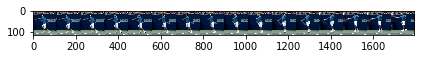

(1, 3, 16, 112, 112)

Top 5:
0.92100 tennis
0.01580 padel tennis
0.01240 softball
0.00891 soft tennis
0.00687 aggressive inline skating


/home/nevin/nevin/projects/ml-exercises/paper-implemenations/c3d-pytorch/C3D_model.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = self.softmax(logits)


In [15]:
main()

In [97]:
def get_blocc(vid):
    arr = []
    for i in range(16):
        arr.append(vid.read()[1])

    blocc = np.array([resize(frame, output_shape=(112, 200), preserve_range=True) for frame in arr])

    blocc = blocc[:, :, 44:44+112, :]
    blocc = blocc.transpose(3, 0, 1, 2)  # ch, fr, h, w
    blocc = np.expand_dims(blocc, axis=0)  # batch axis
    blocc = np.float32(blocc)
    blocc = torch.from_numpy(blocc)
    
    return blocc

In [103]:
def predict(filename):
    # load a clip to be predicted
    #X = X.cuda()
    # get network pretrained model
    net = C3D()
    net.load_state_dict(torch.load('c3d.pickle'))
    #net.cuda()
    net.eval()

    # perform prediction
    
    vid = cv2.VideoCapture(filename)
    ind = 0
    while(vid):
        X = get_blocc(vid)
        X = Variable(X)
        start_time = time.time()
        prediction = net(X)
        prediction = prediction.data.cpu().numpy()
        print("Time taken for prediction =", time.time()-start_time)
        ind = ind+1
        print(ind)

        # read labels
        labels = read_labels_from_file('labels.txt')

        # print top predictions
        top_inds = prediction[0].argsort()[::-1][:5]  # reverse sort and take five largest items
        print('\nTop 5:')
        for i in top_inds:
          print('{:.5f} {}'.format(prediction[0][i], labels[i]))
        if(ind > 10):
            print(ind)
            break

In [104]:
start_time = time.time()
predict('./vid_data/cycling.mp4')
print("Total time taken = ", time.time()-start_time)

/home/nevin/.conda/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/nevin/.conda/envs/pytorch/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/nevin/nevin/projects/ml-exercises/paper-implemenations/c3d-pytorch/C3D_model.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = self.softmax(logits)


Time taken for prediction = 0.6720995903015137
1

Top 5:
0.20809 road bicycle racing
0.11677 cycling
0.11445 supermoto
0.07423 cross-country cycling
0.04752 isle of man tt
Time taken for prediction = 0.6798207759857178
2

Top 5:
0.26924 road bicycle racing
0.14372 supermoto
0.06851 endurance racing (motorsport)
0.06372 cycling
0.06336 motorcycle racing
Time taken for prediction = 0.6800065040588379
3

Top 5:
0.43744 road bicycle racing
0.08998 cycling
0.06943 supermoto
0.04711 endurance racing (motorsport)
0.03954 duathlon
Time taken for prediction = 0.6806516647338867
4

Top 5:
0.15460 road bicycle racing
0.12969 cycling
0.10011 supermoto
0.07300 streetluge
0.03624 longboarding
Time taken for prediction = 0.6812648773193359
5

Top 5:
0.15867 streetluge
0.07571 longboarding
0.05909 orienteering
0.05532 cross-country skiing
0.05489 road bicycle racing
Time taken for prediction = 0.6807212829589844
6

Top 5:
0.19499 streetluge
0.14353 longboarding
0.10169 freeboard (skateboard)
0.05193 s